In [25]:
from google.colab import drive
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from PIL import Image
import matplotlib.pyplot as plt

# Montar Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Carga de imágenes:**

Se define una función llamada "load_images_from_folder" que carga las imágenes de malware desde una carpeta y las convierte en un dataset utilizable. Las imágenes se convierten a escala de grises y se redimensionan a un tamaño de 64x64 píxeles. Las imágenes se almacenan como vectores y se asignan etiquetas a cada imagen según su categoría de malware.

Además creamos dos listas para guardar la primera imagen real de cada carpeta y poder represntarlas antes de cambiarles la dimensión.

In [26]:
# Función para cargar imágenes y mostrar una imagen original de cada subcarpeta
def load_and_preview_images_from_folder(folder):
    images = []
    labels = []
    label = 0
    first_images = []  # Lista para guardar la primera imagen de cada subcarpeta
    image_shapes = []  # Lista para guardar las formas de las primeras imágenes
    for dirname in sorted(os.listdir(folder)):  # Usar sorted para orden consistente
        subfolder = os.path.join(folder, dirname)
        if os.path.isdir(subfolder):
            first_image_loaded = False
            for filename in sorted(os.listdir(subfolder)):
                img_path = os.path.join(subfolder, filename)
                img = Image.open(img_path)  # Abrir imagen sin convertir a escala de grises
                if not first_image_loaded:  # Mostrar la primera imagen sin modificar
                    first_images.append((img.copy(), dirname))  # Guardar una copia y nombre
                    image_shapes.append((img.size, dirname))  # Guardar forma y nombre
                    first_image_loaded = True
                img = img.convert('L').resize((64, 64))  # Convertir y redimensionar
                images.append(np.array(img).flatten())
                labels.append(label)
            label += 1
    return np.array(images), np.array(labels), first_images, image_shapes

folder_path = '/content/drive/My Drive/LAB03/Malware/Malware'
images, labels, previews, shapes = load_and_preview_images_from_folder(folder_path)


Ya hemos observado antes, en la carpeta que la dimesión de las imagenes es distinta, por eso las reajustamos para que sean igual ya que los modelos requieren que los datos de entrada tengan un tamaño uniforme. Al redimensionar las imágenes, se asegura que todas tengan la misma forma y tamaño antes de ser introducidas en el modelo.

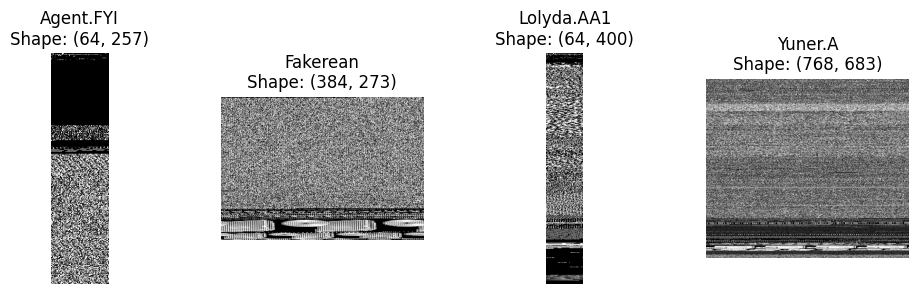

In [27]:
# Mostrar una imagen original de cada subcarpeta y su forma real
fig, axes = plt.subplots(1, len(previews), figsize=(12, 3))
for ax, ((img, name), (shape, _)) in zip(axes, zip(previews, shapes)):
    ax.imshow(img, cmap='gray')
    ax.set_title(f"{name}\nShape: {shape}")
    ax.axis('off')
plt.show()

# **División del dataset:**

 El dataset se divide en conjuntos de entrenamiento y prueba utilizando la función "train_test_split" de la biblioteca scikit-learn. El 80% de las imágenes se utilizan para entrenar el modelo y el 20% se utilizan para evaluar su rendimiento.

In [28]:
# Dividir el dataset en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)


# Verificar las formas de los conjuntos
print("Forma del conjunto de entrenamiento de imágenes:", len(X_train))
print("Forma del conjunto de evaluación de imágenes:", len(X_test))


Forma del conjunto de entrenamiento de imágenes: 372
Forma del conjunto de evaluación de imágenes: 93


#**Configuración de clasificadores:**

Se definen tres configuraciones de clasificadores SVM con diferentes kernels (lineal, polinomial y RBF). Cada kernel representa una forma diferente de trazar la línea que separa las clases en el espacio de características.  Se ajusta cada clasificador utilizando el conjunto de entrenamiento y se evalúa su precisión utilizando el conjunto de prueba.

In [29]:
# Configuración de clasificadores
kernels = ['linear', 'poly', 'rbf']
results = []

for kernel in kernels:
    clf = make_pipeline(StandardScaler(), PCA(n_components=50), SVC(kernel=kernel))
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    results.append((kernel, accuracy))


# **Resultados:**

Se muestran los resultados de cada clasificador en una tabla que muestra el kernel utilizado y la precisión obtenida.

In [30]:
# Mostrar resultados en una tabla
print("Resultados de la precisión por tipo de kernel:")
for kernel, accuracy in results:
    print(f"Precisión del clasificador SVM con kernel {kernel} es de {accuracy:.2f}")


Resultados de la precisión por tipo de kernel:
Precisión del clasificador SVM con kernel linear es de 1.00
Precisión del clasificador SVM con kernel poly es de 1.00
Precisión del clasificador SVM con kernel rbf es de 1.00


Los resultados obtenidos indican una precisión del 100% para todos los kernels. Aunque esto podría sugerir un rendimiento perfecto, hay algunas consideraciones a tener en cuenta:

-Una precisión del 100% puede ser una señal de sobreajuste, especialmente si el conjunto de datos de prueba es pequeño.

-La alta precisión también puede deberse a la calidad de los datos. Como las imágenes de malware tienen características muy distintivas y no hay mucha superposición entre las clases, es más fácil para el modelo hacer predicciones precisas.


# **Clasificación de nuevas imágenes:**

 Se seleccionan aleatoriamente 10 imágenes del conjunto de prueba y se utilizan para evaluar el modelo seleccionado. Se muestra la predicción realizada por el clasificador y la categoría real de cada imagen.

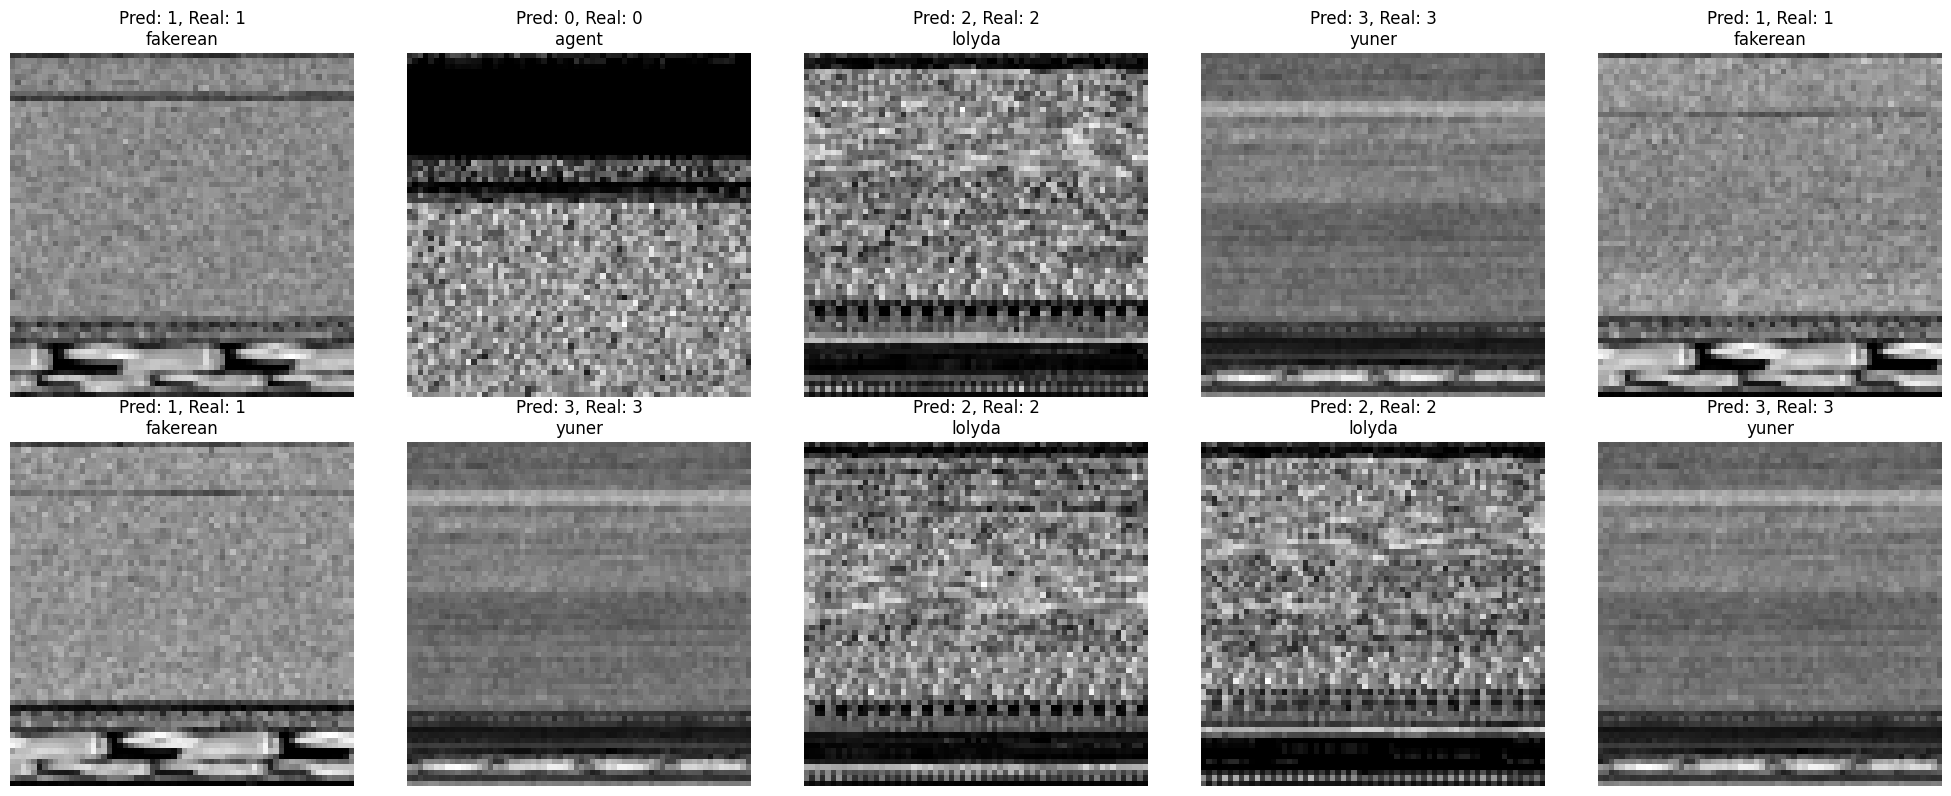

In [32]:
# Diccionario de etiquetas
label_descriptions = {
    0: "agent",
    1: "fakerean",
    2: "lolyda",
    3: "yuner"  # Añade más si hay más tipos
}

# Clasificar 10 imágenes nuevas
sample_indices = np.random.choice(range(len(X_test)), 10, replace=False)
sample_images = X_test[sample_indices]
sample_labels = y_test[sample_indices]
predictions = clf.predict(sample_images)

# Configuración de la visualización de resultados
fig, axes = plt.subplots(2, 5, figsize=(20, 8))  # Ajusta al número de imágenes
axes = axes.flatten()

for i, (image, pred, real) in enumerate(zip(sample_images, predictions, sample_labels)):
    ax = axes[i]
    ax.imshow(image.reshape(64, 64), cmap='gray')  # Asumiendo que cada imagen es 64x64
    description = label_descriptions[real]  # Obtener la descripción de la etiqueta real
    ax.set_title(f"Pred: {pred}, Real: {real}\n{description}")
    ax.axis('off')

plt.tight_layout()
plt.show()